In [2]:
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings

In [3]:
def run_simulation(returns, prices, amt, order, thresh, verbose=False, plot=True):
    if type(order) == float:
        thresh = None
        
    curr_holding = False
    events_list = []
    init_amt = amt

    #go through dates
    for date, r in tqdm (returns.iloc[14:].items(), total=len(returns.iloc[14:])):
        #if you're currently holding the stock, sell it
        if curr_holding:
            sell_price = prices.loc[date]
            curr_holding=False
            ret = (sell_price-buy_price)/buy_price
            amt *= (1+ret)
            events_list.append(('s', date, ret))
            
            if verbose:
                print('Sold at $%s'%sell_price)
                print('Predicted Return: %s'%round(pred,4))
                print('Actual Return: %s'%(round(ret, 4)))
                print('=======================================')
            continue

        #get data til just before current date
        curr_data = returns[:date]
        
        if type(order) == tuple:
            try:
                #fit model
                model = ARIMA(curr_data, order=order).fit()
                #get forecast
                pred = model.forecast()[0][0]

            except:
                pred = thresh - 1



        #if you predict a high enough return and not holding, buy stock
        if (not curr_holding) and \
        ((type(order) == float and np.random.random() < order) 
         or (type(order) == tuple and pred > thresh)
         or (order == 'last' and curr_data[-1] > 0)):
            
            curr_holding = True
            buy_price = prices.loc[date]
            events_list.append(('b', date))
            if verbose:
                print('Bought at $%s'%buy_price)
                
    if verbose:
        print('Total Amount: $%s'%round(amt,2))
        
    #graph
    if plot:
    
        plt.figure(figsize=(10,4))
        plt.plot(prices[14:])

        y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
        shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims), 
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100*(amt / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title("%s Price Data\nThresh=%s\nTotal Amt: $%s\nTotal Return: %s"%(tickerSymbol, thresh, round(amt,2), tot_return), fontsize=20)
        plt.ylim(*y_lims)
        plt.show()
    
    return amt

In [4]:
# model = ARIMA(returns.loc[:returns.index[100]], order=(30,0,0)).fit()
# print(model.summary())

In [5]:
tickerSymbol = 'DIS'
start_date = "2023-01-01"
end_date = "2024-01-01"
df = yf.download(tickerSymbol, start=start_date, end=end_date, interval='1h')
df.dropna(axis=1, inplace=True)
prices = df['Close']
# prices = data.history(start='2021-01-01', end='2021-04-01').Close
returns = prices.pct_change().dropna()
# returns = prices.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [6]:
# # returns = df.Close.pct_change().dropna()
# # prices = df['Close']
# tickerSymbol = 'AAPL'
# data = yf.Ticker(tickerSymbol)
# prices = data.history(start='2021-01-01', end='2021-04-01').Close
# returns = prices.pct_change().dropna()

Text(0.5, 1.0, 'DIS Returns')

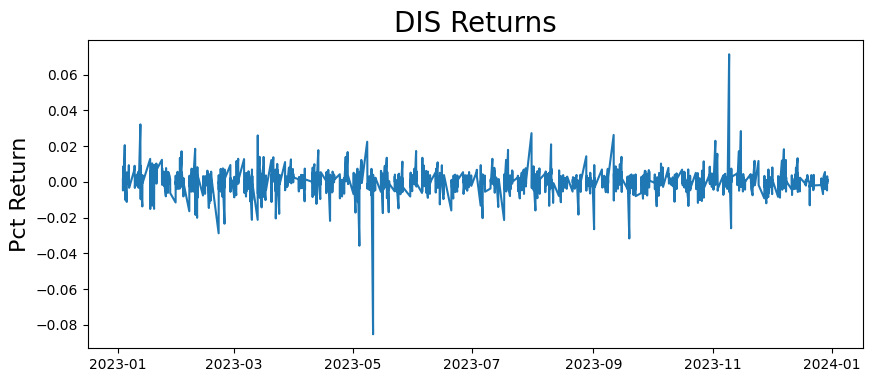

In [7]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title(tickerSymbol + ' Returns', fontsize=20)

In [17]:
start_date = '2023-01-01'
end_date = '2023-03-01'
tickers = ['NXE', 'CCL', 'PR', 'STNE', 'NAT', 'AMD', 'NVDA', 'UEC', 'XP', 'TSLA']
for ticker in tickers:
    print(ticker)
    df = yf.download(ticker, start=start_date, end=end_date, interval='1d')
    df.dropna(axis=1, inplace=True)
    prices = df['Close']
# prices = data.history(start='2021-01-01', end='2021-04-01').Close
    returns = prices.pct_change().dropna()
    plot_acf(returns, lags=100)
    plt.show()

NXE


KeyboardInterrupt: 

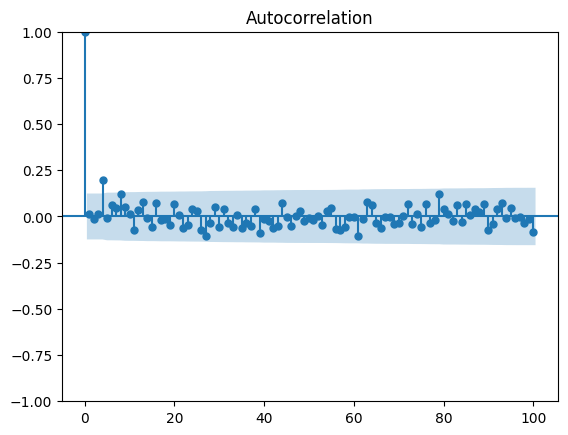

In [9]:
plot_acf(returns, lags=100)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(returns)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.384429
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


In [11]:
final_amts = [run_simulation(returns, prices, 100, 0.5, None, verbose=False, plot=False) for _ in range(100)]

100%|██████████| 235/235 [00:00<00:00, 31299.78it/s]


Text(0.5, 1.0, 'Avg: $125.91\nSD: $31.46')

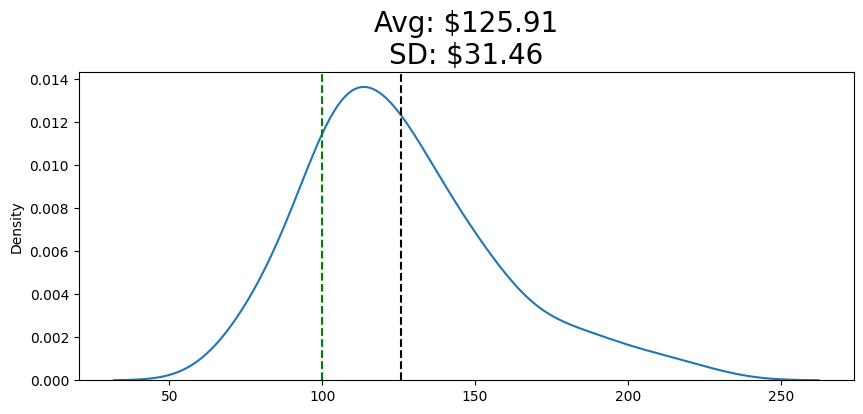

In [12]:
plt.figure(figsize=(10,4))
sns.kdeplot(final_amts)
plt.axvline(np.mean(final_amts), color='k', linestyle='--')
plt.axvline(100, color='g', linestyle='--')
plt.title('Avg: $%s\nSD: $%s'%(round(np.mean(final_amts),2), round(np.std(final_amts),2)), fontsize=20)

100%|██████████| 235/235 [00:00<00:00, 28246.49it/s]


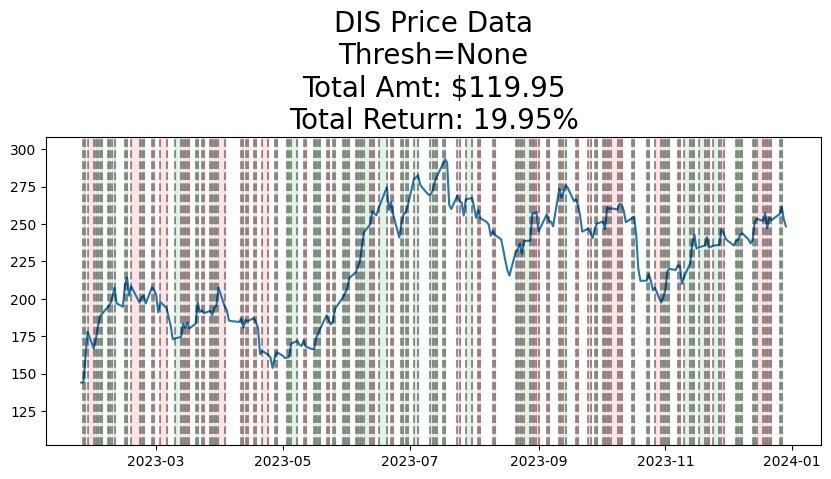

119.95210947399539

In [13]:
run_simulation(returns, prices, 100, 'last', None, verbose=False)

  0%|          | 0/235 [00:00<?, ?it/s]C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

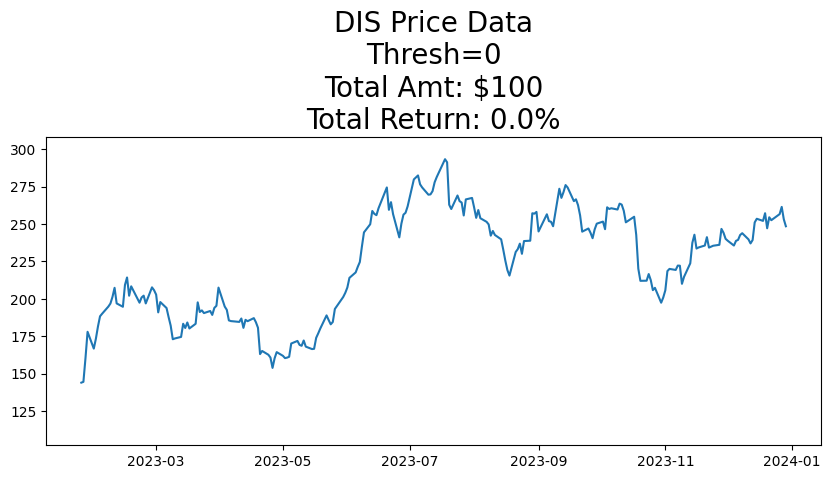

  0%|          | 0/235 [00:00<?, ?it/s]C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

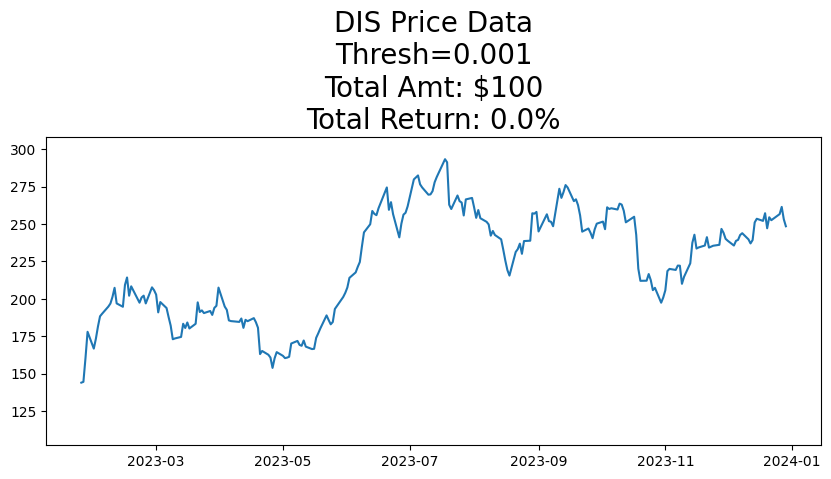

  0%|          | 0/235 [00:00<?, ?it/s]C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no asso

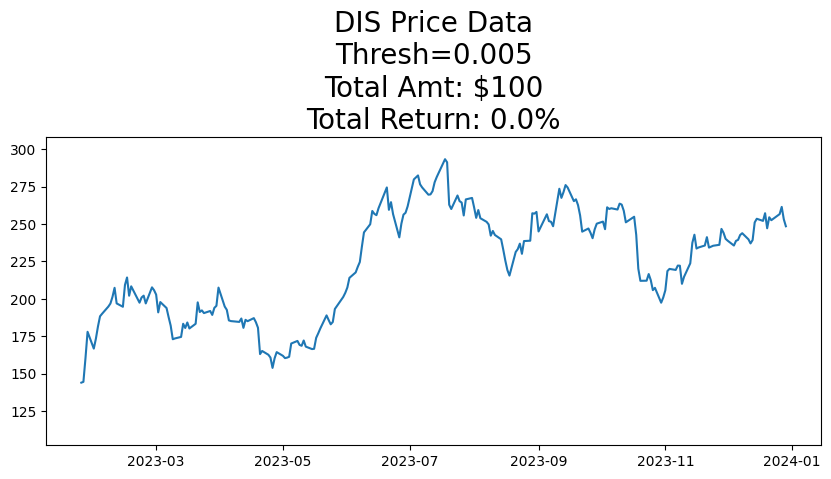

In [14]:
for thresh in [0, 0.001, 0.005]:
    run_simulation(returns, prices, 100, (1,0,0), thresh, verbose=False)

In [28]:
ff_factors = pd.read_csv('data/famafrench_daily_factor.csv')

In [29]:
ff_factors.drop(['Date_str'], axis=1, inplace=True)
ff_factors = ff_factors.set_index('Date')
ff_factors.index = pd.to_datetime(ff_factors.index)

In [42]:
from datetime import datetime
ff_factors = ff_factors.loc[datetime(2023,1,1):]

<Figure size 640x480 with 0 Axes>

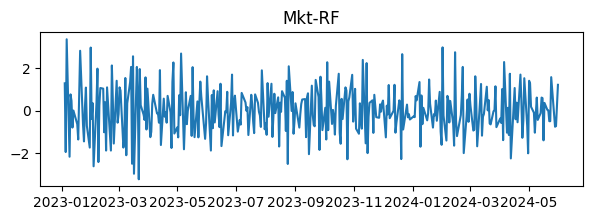

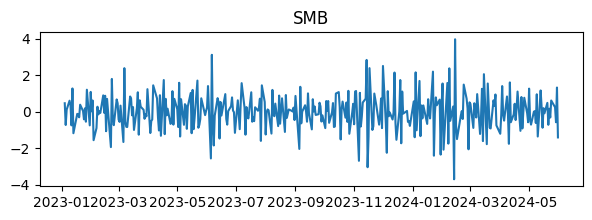

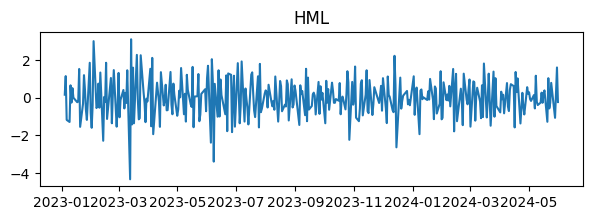

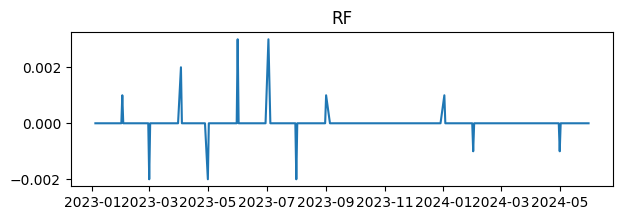

In [64]:
plt.figure()
for factor in list(ff_factors.columns):
    plt.figure(figsize=(7,2))
    plt.plot(ff_factors[factor].diff())
    plt.title(f"{factor}")
    plt.show()

<Figure size 700x200 with 0 Axes>

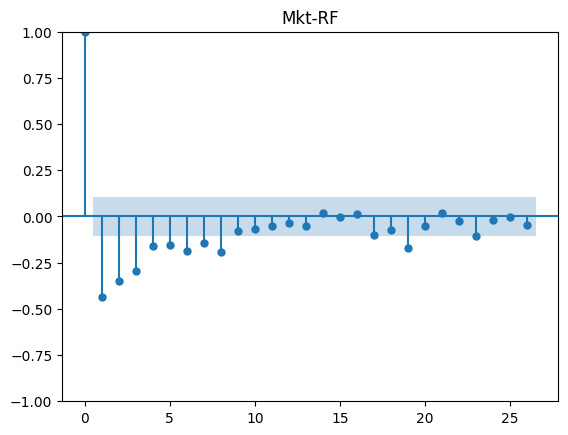

<Figure size 700x200 with 0 Axes>

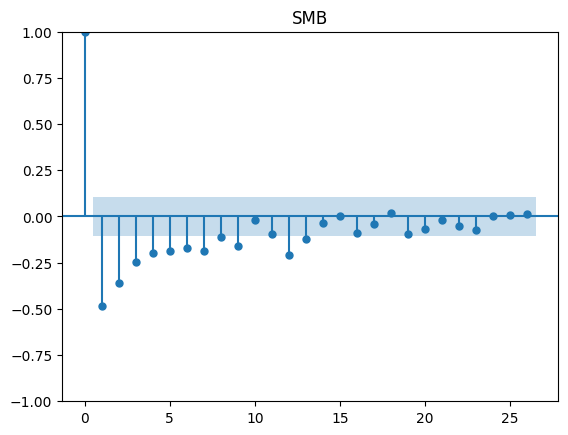

<Figure size 700x200 with 0 Axes>

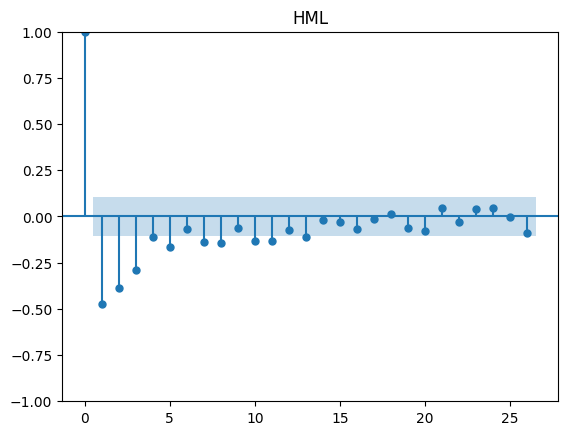

<Figure size 700x200 with 0 Axes>

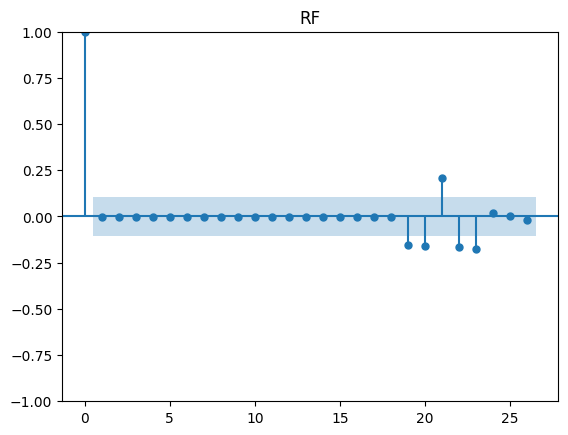

In [67]:
# fig, ax = plt.subplots(nrows=3, ncols=1)
for i, factor in enumerate(list(ff_factors.columns)):
    plt.figure(figsize=(7,2))
    plot_pacf(ff_factors[factor].diff().dropna())
    plt.title(f"{factor}")
    plt.show()

In [69]:
model = ARIMA(ff_factors['HML'], order=(4,1,4)).fit()
#get forecast
pred = model.forecast()

C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Liu Tsun Hei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so wil

In [72]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    HML   No. Observations:                  355
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -383.545
Date:                Sun, 28 Jul 2024   AIC                            785.091
Time:                        17:06:50   BIC                            819.914
Sample:                             0   HQIC                           798.946
                                - 355                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.1308      0.319     -6.676      0.000      -2.756      -1.505
ar.L2         -2.0831      0.421     -4.944      0.000      -2.909      -1.257
ar.L3         -0.9028      0.351     -2.570      0.010      -1.591      -0.214
ar.L4         -0.0131      0.061     -0.215      0.830      -0.133       0.106
ma.L1          1.1624      0.468      2.483      0.013       0.245       2.080
ma.L2         -0.0519      0.774     -0.067      0.947      -1.568       1.464
ma.L3         -1.2337      0.757     -1.630      0.103      -2.717       0.250
ma.L4         -0.8762      0.435     -2.013      0.044      -1.730      -0.023
sigma2         0.5003      0.174      2.882      0.004       0.160       0.841
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                18.54
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""